In [92]:
import pandas as pd
import geopandas
import numpy as np
from math import pi
from matplotlib import pyplot as plt
import seaborn as sns

### Configuraciones librerias

In [93]:
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (18, 8)

sns.set(style="whitegrid", font_scale = 2) # seteando tipo de grid en seaborn
                                           # seteando tamanio de ticks label
pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

### Configuraciones plot

In [119]:
TAM_TITULO = 35
TAM_ETIQUETA = 30
COLORES_BARRAS = 'colorblind'

### Funciones auxiliares

In [94]:
font_size = 18

def crear_mapa(series, caracteristica, vmin, vmax, titulo, color):
    #Creo mi mapa de mexico
    mexico = geopandas.read_file('Data/mexstates.shp') #Los estados pueden ser vistos con mexico.ADMIN_NAME

    #Le pongo los tildes al archivo de estados para que me coincidan con las provincias
    mexico["ADMIN_NAME"].replace({'Nuevo Leon': "Nuevo León",
                               "San Luis Potosi": "San luis Potosí",
                               "Queretaro": "Querétaro",
                               "Yucatan": "Yucatán",
                               "Michoacan": "Michoacán",
                               "Mexico": "Edo. de México",
                               "Baja California": "Baja California Norte"}, inplace=True)

    #Hago un nuevo dataframe con la información del mapa y la antiguedad para cada provincia
    gdf = mexico.set_index("ADMIN_NAME").join(series)
    
    #Grafico el mapa

    #Base donde se va a dibujar
    fig, base = plt.subplots(1, figsize=(10, 6))

    #Saco los ejes de lat y lng ya que no aportan al gráfico
    base.axis("off")

    #Pido que me coloreé en base a la antiguedad
    gdf.plot(column=caracteristica, cmap=color, linewidth=0.8, ax=base, edgecolor="0.8")

    #Setteo el título al gráfico
    base.set_title(titulo, fontsize = font_size)
    
    #Agrego la barra que indica la antiguedad
    sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm)
    

### Carga optimizada del set de datos

In [95]:
df = pd.read_csv('train.csv', \
       dtype = { \
                'id' : np.int32, \

                'ciudad' : 'category', \
                'antiguedad' : np.float16, \
                'habitaciones' : np.float16, \
                'garages' : np.float16, \
                'banos' : np.float16, \
                'metroscubiertos' : np.float16, \
                'metrostotales' : np.float16, \
                'idzona' : np.float32, \
                'gimnasio' : 'bool', \
                'usosmultiples' : 'bool', \
                'piscina' : 'bool', \
                'escuelascercanas' : 'bool', \
                'centroscomercialescercanos' : 'bool', \
                'precio' : np.float32 \
               },
        parse_dates = ['fecha'],
        date_parser = pd.to_datetime                                
    )

## Cantidad de NAN en campos a analizar

### Cantidad de NAN en provincia:

In [96]:
n_provincia_nan = df["provincia"].isnull().sum()
n_provincia_nan

155

### Cantidad de NAN en escuelascercanas:

In [97]:
n_tipodepropiedad_nan = df["escuelascercanas"].isnull().sum()
n_tipodepropiedad_nan

0

In [98]:
df = df.dropna(subset=["provincia"])

## Valores

### ¿Qué valores puede tomar escuelascercanas?

In [99]:
escuelascercanas_valores = df["escuelascercanas"].unique()
escuelascercanas_valores.sort()
escuelascercanas_valores

array([False,  True])

### ¿Cuál es el promedio de escuelas cercanas para una propiedad por provincia?

In [100]:
provincia_promedio_escuelas = df.groupby("provincia")["escuelascercanas"].mean()

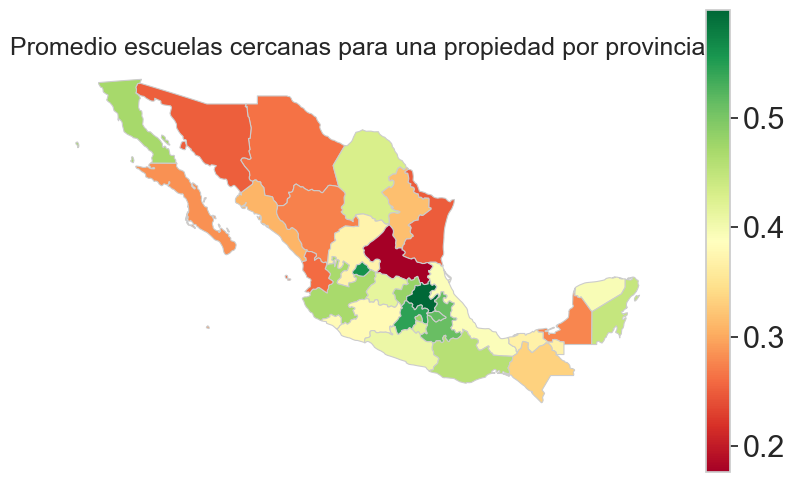

In [101]:
crear_mapa(provincia_promedio_escuelas, "escuelascercanas", provincia_promedio_escuelas.min(),
           provincia_promedio_escuelas.max(), "Promedio escuelas cercanas para una propiedad por provincia", "RdYlGn")

## ¿Varía en promedio el precio de las propiedades según si tienen escuelas cercanas por provincia?

In [104]:
provincias_validas = df["provincia"].value_counts() > 10500
provincias_validas = provincias_validas[provincias_validas == True]
df_reducido = df[df["provincia"].isin(list(provincias_validas.index))]

def crear_df_precio_escuelascercanas_boolean(df):
    provincias = df["provincia"].unique()
    
    df_escuelascercanas_true = df[df["escuelascercanas"] == True]
    df_escuelascercanas_false = df[df["escuelascercanas"] == False]
    
    precio_escuelascercanas_true = df_escuelascercanas_true.groupby("provincia")["precio"].mean()
    precio_escuelascercanas_false = df_escuelascercanas_false.groupby("provincia")["precio"].mean()
    
    provincias_col = []
    boolean = []
    precio = []
    
    for provincia in provincias:
        #Para verdadero
        provincias_col.append(provincia)
        boolean.append(True)
        precio.append(precio_escuelascercanas_true[provincia])
        
        #Para falso
        provincias_col.append(provincia)
        boolean.append(False)
        precio.append(precio_escuelascercanas_false[provincia])
    
    dic = {"provincias": provincias_col, "escuelacercanas": boolean, "precio": precio}
    return pd.DataFrame(dic)

df_escuelascercanas_precio_boolean = crear_df_precio_escuelascercanas_boolean(df_reducido)
df_escuelascercanas_precio_boolean

,provincias,escuelacercanas,precio
0,Distrito Federal,True,"3,417,376.25"
1,Distrito Federal,False,"3,521,510.00"
2,Jalisco,True,"2,438,989.00"
3,Jalisco,False,"2,304,753.75"
4,Edo. de México,True,"2,696,654.25"
5,Edo. de México,False,"2,841,233.50"
6,Nuevo León,True,"2,407,734.50"
7,Nuevo León,False,"2,861,878.00"
8,Querétaro,True,"2,156,901.00"
9,Querétaro,False,"2,132,237.25"


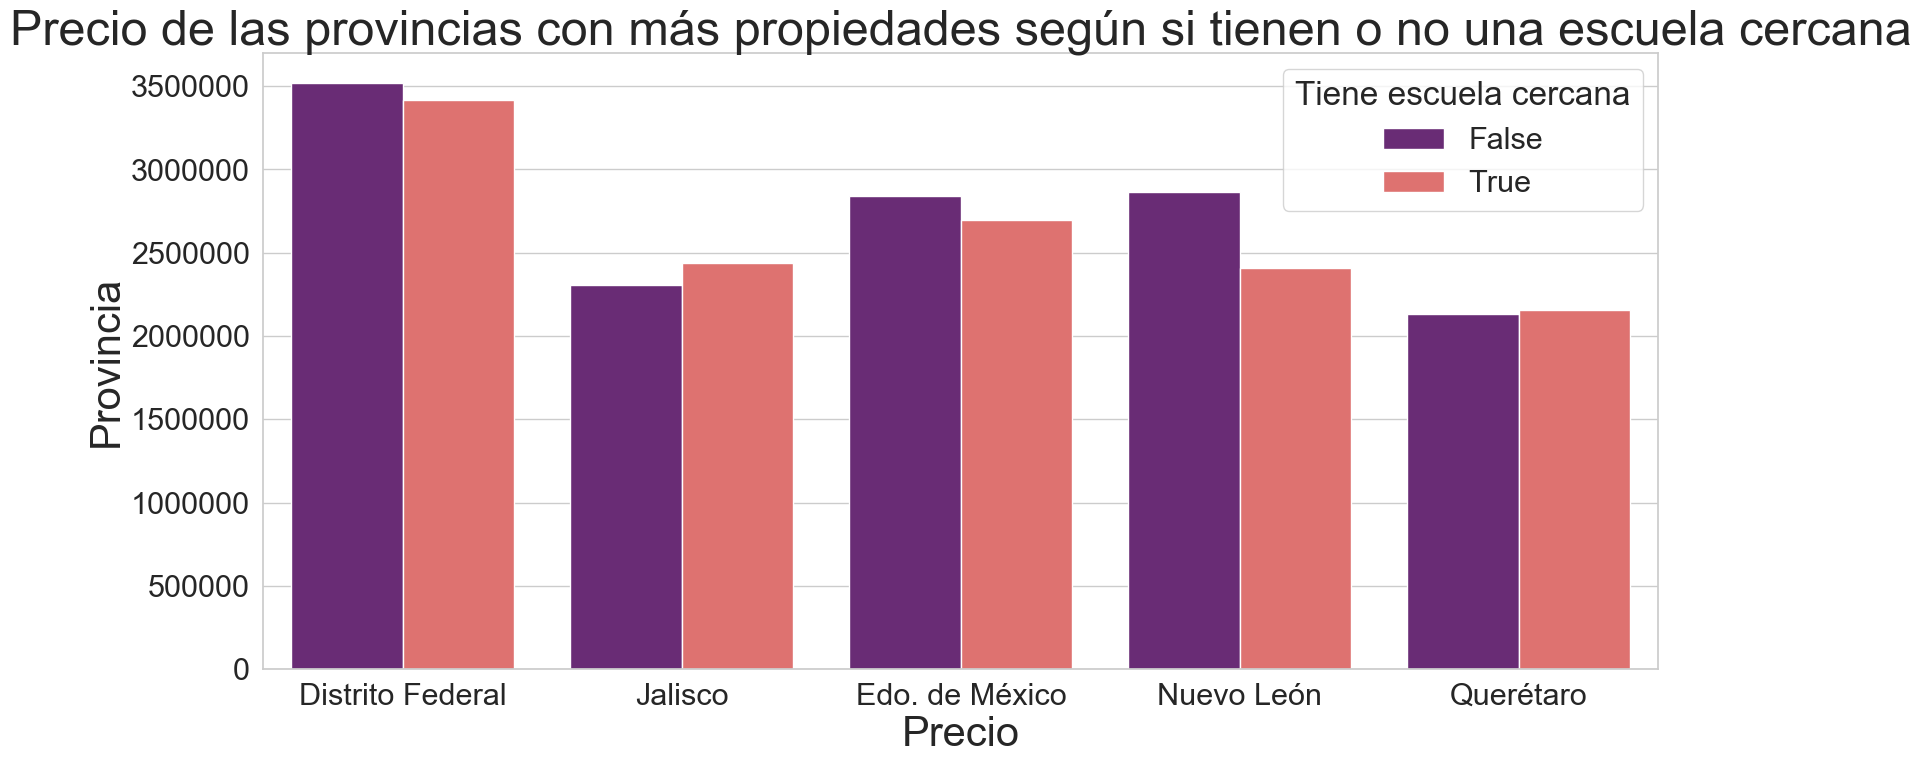

In [122]:
plot_escuelascercanas_precio_boolean = sns.barplot(
                                    x = 'provincias', 
                                    hue = 'escuelacercanas',
                                    y = 'precio',
                                    data = df_escuelascercanas_precio_boolean,
                                    palette = "magma"
                                )

plot_escuelascercanas_precio_boolean.set_title(
    "Precio de las provincias con más propiedades según si tienen o no una escuela cercana", fontsize = TAM_TITULO
)
plot_escuelascercanas_precio_boolean.set_xlabel('Precio', fontsize = TAM_ETIQUETA)
plot_escuelascercanas_precio_boolean.set_ylabel('Provincia', fontsize = TAM_ETIQUETA)
plot_escuelascercanas_precio_boolean.legend(title = 'Tiene escuela cercana')
plt.show()

## ¿Las provincias con propiedades más caras poseen mayor promedio de escuelas cercanas por propiedad?